# Disease, Epidemics and Vaccination Effectiveness through Agent Based Modeling

### Robert Bowen, Evan Fallis & Hannah Szentimrey

#### Winter 2018

This notebook contains the model used to explore different factors with epidemics. Some parts of this code was taken from the Sugarscape model developed by Allen Downey, specifically the chap09.ipynb notebook used in Lab 10. 

The following cell contains all of the packages required to run the model. The Cell2D.py, thinkplot.py and thinkstats2.py all have to be in the same directory as this notebook in order for the model to work.

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from matplotlib import rc
rc('animation', html='html5')

from scipy.signal import correlate2d

from Cell2D import Cell2D, Cell2DViewer

import thinkplot
from thinkstats2 import RandomSeed

The following cell contains the Agent class. An instance of this class represent one agent or person in the model. Each agent has the following attributes:

* `loc`: Current location of the agent. This is represented as a tuple as (x, y).
* `vaccinated`: A boolean value to say if the agent has been vaccinated or not. 
* `remaining_infection_time`: The amount of time the agent has remaining for being sick. This is represented as an integer.
* `state`: An integer representing the current state of the agent. There are three possible states:
    * `Vulnerable`: `1`. A vulnerable agent is an agent who has not had the disease before and can possibly get the illness. If an agent is vaccinated, the agent can still get sick, but has a very low chance (depending on the vaccination effectiveness).
    * `Sick`: `2`. A sick agent is an agent who currently has the disease and can spread it to vulnerable agents. The disease is deadly, and the agent has the possibility of dying after each time step when they are sick.
    * `Survived`: `3`. A survived agent is an agent who was sick for the full infection time of the disease and has currently been "cured"/fought off the illness. A survived agent cannot become sick again with the disease and continues to live in the model.


In [2]:
# Part of this class was taken and modified from lab 10
class Agent:
    
    def __init__(self, loc, vaccinated):
        """Creates a new agent at the given location.
        loc: tuple coordinates
        vaccinated: boolean """
        
        self.loc = tuple(loc)
        self.vaccinated = vaccinated
        self.remaining_infection_time = 0
        self.state = 1 # Set the agent to be vulnerable (2 = sick, 3 = survived)
                
    def step(self, env):
        """Look around for empty space and move there.
        Also determine if the agent has survived the disease or
        calculate the new remaining infection time if sick.
        env: Disease environment """
        
        self.loc = env.look_for_empty_spot(self.loc)
        
        if (self.state == 2) & (self.remaining_infection_time == 0): # agent has survived the disease
            self.state = 3 
        elif self.state == 2: # decrement the remaining amount of time with disease
            self.remaining_infection_time = self.remaining_infection_time - 1 
        
    def make_sick(self, time):
        """Make the agent sick by setting the state
        and remaining infection time for the agent.
        time: integer """
        
        self.state = 2
        self.remaining_infection_time = time

Various parameters can be changed in the model and simulated to test different scenarios. The different parameters that can be changed are:

* `num_agents`: The number of agents in the simulation. 
    * Range: 1 to $n^2$ 
    * Default value: `400`
* `vaccination_rate`: The percentage of agents that are vaccinated at the start of the simulation. 
    * Range: 0 to 1
    * Default value: `0.9`
* `infection_range`: The number of spaces away a sick agent is able to infect a vulnerable agent. This is in all directions from the sick agent, including diagonal lines. 
    * Range: 1 to $n/2$
    * Default value: `1`
* `infection_time`: The number of time steps a sick agent is sick for. Once the infection time has elapsed, the agent then changes to the survived state.
    * Range: greater than 1
    * Default value: `3`
* `vaccine_effect`: The percent effectiveness of the vaccine given to the agents.  
    * Range: 0 to 1
    * Default value: `0.8`
* `infection_rate`: The percent chance a sick agent gets a vulnerable agent sick. The chance a vulnerable agent gets sick also depends on the number of sick agents around and the vaccine effeciveness, if the agent has been vaccinated.
    * Range: 0 to 1
    * Default value: `0.6`
* `survival_rate`: The percent chance a sick agent stays alive at the end of a time step.  
    * Range: 0 to 1
    * Default value: `0.8`


In [3]:
# Part of this class was taken and modified from lab 10
class Disease(Cell2D):
    
    def __init__(self, n, seed=None, **params):
        """Creates a new environment for the agents and disease.
        n: width and height of the environment.
        seed: integer
        params: parameters for simulation (see above cell)"""
        
        self.n = n
        self.params = params
        
        # Sets a seed for randomness so simulations and experiments can be repeated
        if seed is not None:
            np.random.seed(seed)
        
        # Create array
        self.array = np.zeros((n,n), dtype=int)
        
        # Track certain variables to plot over time
        self.agent_count_seq = []
        
        # Create the kernel 
        infection_range = self.params.get('infection_range', 1)
        kernel_n = infection_range * 2 + 1
        self.kernel = np.ones((kernel_n, kernel_n))
        self.kernel[infection_range, infection_range] = 0        
        
        # Create the agents for the simulation
        self.make_agents()
        
        # Create patient zero (ie one agent starts out sick)
        infection_time = self.params.get('infection_time', 3)
        self.agents[0].make_sick(infection_time)
    
    def make_agents(self):
        """Place agents on cells and vaccinate a portion of the agents."""
        
        # Generate locations and determine where the agents start
        n, m = self.array.shape
        locs = self.make_locs(n, m)
        np.random.shuffle(locs)

        # Get the parameters needed to make agents
        num_agents = self.params.get('num_agents', 400)
        vaccination_rate = self.params.get('vaccination_rate', 0.9)
        
        # Calculate the number of vaccinated and unvaccinated agents
        num_vacc_agents = int(num_agents * vaccination_rate)
        num_unvacc_agents = num_agents - num_vacc_agents
        
        # Create the vaccinated or unvaccinated agents
        self.agents = [Agent(locs[i], vaccinated= (i < num_vacc_agents)) 
                       for i in range(num_agents)]
        
        # Keep track of which cells are occupied
        self.occupied = set(agent.loc for agent in self.agents)
    
    # Taken from lab 10
    def make_locs(self, n, m):
        """Makes array where each row is an index in an `n` by `m` grid.

        n: int number of rows
        m: int number of cols

        returns: NumPy array
        """
        left = np.repeat(np.arange(m), n)
        right = np.tile(np.arange(n), m)
        return np.transpose([left, right])
    
    # Taken and modified from lab 10
    def look_for_empty_spot(self, center):
        """Look for an empty location and return it to agent
        center: agent's current location"""
        
        # Create an array with all of the visible locations relative to position (0, 0)
        # This allows agents to move one space in any direction from their current cell,
        # including diagonal directions
        visible = np.array([
                    [-1, -1],
                    [-1,  0],
                    [-1,  1],
                    [ 0, -1],
                    [ 0,  1],
                    [ 1, -1],
                    [ 1,  0],
                    [ 1,  1]
                    ], 
                  dtype=np.int32)
        
        # Find all of the visible positions around the center point
        # This allows agents to move and wrap around the border
        locs = (visible + center) % self.n
        
        # Taken from lab10
        # This takes all of the locations the agent sees and 
        # finds which locations are currently empty
        locs = [tuple(loc) for loc in locs]
        empty_locs = [loc for loc in locs if loc not in self.occupied]
        
        # Taken from lab10
        # If there are no empty locations around the agent, then the 
        # agent stays in place
        if len(empty_locs) == 0:
            return center
        
        # Picks a random empty location to move to
        np.random.shuffle(empty_locs)
        
        return empty_locs[0]
    
    def step(self):
        """Executes one time step of the model.
        This includes making agents sick and determining
        if the sick agents are alive or dead."""
        
        sickAgent = np.zeros((self.n, self.n))
        
        # Find all of the sick agents and fill an array 
        for agent in self.agents:
            if agent.state == 2: #If the agent is sick
                sickAgent[agent.loc] = 1
    
        # Find all of the locations that are exposed to a sick agent and how many sick agents
        diseaseSpread = correlate2d(sickAgent, self.kernel, mode='same', boundary='wrap', fillvalue=0)
        
        # Get the parameters for the disease
        infection_rate = self.params.get('infection_rate', 0.6)
        vaccine_effect = self.params.get('vaccine_effect', 0.8)
        infection_time = self.params.get('infection_time', 3)
        survival_rate = self.params.get('survival_rate', 0.8)
        
        # Determine if a vulnerable agent is exposed to the disease
        for agent in self.agents:
            if (diseaseSpread[agent.loc] > 0) & (agent.state == 1): #can only get sick if vulnerable
                
                # Determine the infection rate of the agent. The infection rate increases
                # for an agent as the number of sick agents around increases
                contact_infection_rate = 1 - ((1 - infection_rate) ** diseaseSpread[agent.loc])
                
                # Determine if the agent gets sick depending on the infection rate and if they are vaccinated.
                if (agent.vaccinated == False) & (np.random.random() < contact_infection_rate):
                    agent.make_sick(infection_time)
                elif (agent.vaccinated == True) & (np.random.random() < contact_infection_rate*(1-vaccine_effect)):
                    agent.make_sick(infection_time)
        
        # Part of this loop was taken from lab10        
        # loop through the agents in random order
        random_order = np.random.permutation(self.agents)
        for agent in random_order:
            
            # mark the current cell unoccupied
            self.occupied.remove(agent.loc)
                        
            if (agent.state == 2) & (np.random.random() < 1 - survival_rate): # if the agent didn't survive
                self.agents.remove(agent)
            else:
                # execute one step
                agent.step(self)
                self.occupied.add(agent.loc)
        
        # Keep track of the number of agents still left alive
        self.agent_count_seq.append(len(self.agents))

        return len(self.agents)

In the `step` method in the `Disease` class, there is a calculation to determine the infection rate for an agent based on the number of sick agents they are exposed to. The calculation was:

`contact_infection_rate = 1 - ((1 - infection_rate) ** diseaseSpread[agent.loc])`

This is equivalent to:

$Contact Infection Rate = 1 - (1 - Infection Rate)^k$,

where $k$ is the number of sick agents around the agent. This calculation is based on probibility theory. To calculate the probability that the agent will be sick from one or more of the sick agents, it is easier to calculate the probability of the agent not getting sick and subtract that value from 1. To calculate the probability of the agent not getting sick from one sick agent, it is $1-Infection Rate$. If there are two sick agents around, the probability is $(1-Infection Rate)(1-Infection Rate)$. This pattern can increase to $k$ sick agents. This probability is then subtracted by 1 to get the new infection rate.

In the `Disease` class, the `infection_range` parameter is used to create a kernel used in the correlate function with an array of sick agents' locations. In order to create the kernel, an array of size $2n + 1$ is created full of 1's, where $n$ is the infection range. The center of the array is set to 0. This creates a kernel that finds the spread of disease if it can spread $n$ spaces away in any direction. 

The `Disease` class is able to take a seed for the random functions. This is to allow the same seed to be used across different simulations. This is because if the same seed is not used and a parameter is changed to see the effect it has on the agents, the seed allows the same initial condition for each pass. If there was no seed passed, then the initial condition of each simulation would be different, making the results impossible to compare. 

The `DieaseViewer` class is used to visualize the model. This involves creating the evnrionment and placing the agents in the environment within a grid. Since there are three states each agent can be in and each agent can either be vaccinated or unvaccinated, there are 4 different colours an agent can be coloured as. The following is a legend for the colouring:

* `Vulnerable & Unvaccinated`: Blue
* `Vulnerable & Vaccinated`: Purple
* `Sick`: Red
* `Survived`: White

In order to colour each agent individually, the agents are plotted as a scatter plot. The colour is determined for each agent and added to a list in the same order the agent's x and y value are added to their respective lists. 

In addition, a function was implmeneted in order to add a legend to the viewer to show which colours map to which state. This can be seen in the simulations below using the `DiseaseViewer` class. Note that there is a bug where the legend does not appear correctly when the viewer is animated. 

In [4]:
# This was taken from lab 10 and modified for the project
class DiseaseViewer(Cell2DViewer):
    """Generates visualization and animation of DiseaseViewer."""
    
    # Set the background of the viewer to be dark grey/black
    cmap = plt.get_cmap('gray')
    
    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=9)
    
    # This was taken from lab 10
    def draw(self, grid=False):
        """Draws the array and the agents."""
        
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    # This was taken and modified from lab 10
    def draw_agents(self):
        """Plots the agents. The agents colour change based on their state."""
        
        xs, ys, colour = self.get_coords()
        self.points = plt.scatter(xs, ys, marker='.', c=colour)
        self.create_legend()
        
    # This was taken and modified from lab 10
    def animate_func(self, i):
        """Draws one frame of the animation."""
        
        Cell2DViewer.animate_func(self, i)
        xs, ys, colour = self.get_coords()
        self.points.set_offsets(np.c_[xs,ys])
        self.points.set_color(colour)
        return self.im, self.points
    
    # This was taken and modified from lab 10
    def get_coords(self):
        """Gets the coordinates of the agents. Transforms from (row, col) to (x, y).
        This includes setting the correct colours for the agents based on their 
        state and if they are vaccinated or not. 
        returns: tuple of sequences with colour, (xs, ys, colour)"""
        
        agents = self.viewee.agents
        rows, cols = np.transpose([agent.loc for agent in agents])
            
        # Determine the colours of the agents based on state and vaccination
        colour = []
        for agent in agents:
            if((agent.state == 1) & (agent.vaccinated == False)): #vulnerable
                colour.append('#00ecff') #light blue
            elif(agent.state == 2): #sick
                colour.append('#ff0000') #red
            elif(agent.state == 3): #survived
                colour.append('#FFFFFF') #white
            elif((agent.state == 1) & (agent.vaccinated == True)): #vulnerable
                colour.append('#9966ff') #purple
                        
        xs = cols + 0.5
        ys = rows + 0.5
        
        return xs, ys, colour
    
    def create_legend(self):
        """Creates legend for viewer for the colour coding of agents."""
        # Makes legend for colour coding of agents
        light_blue_patch = mpatches.Patch(color='#00ecff', label='Vulnerable & Unvaccinated')
        purple_patch = mpatches.Patch(color='#9966ff', label='Vulnerable & Vaccinated')
        red_patch = mpatches.Patch(color='#ff0000', label='Sick')
        white_patch = mpatches.Patch(color='#FFFFFF', label='Survived')
        
        plt.legend(handles=[light_blue_patch, purple_patch, red_patch, white_patch], 
                   bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., facecolor="grey")
        
        plt.tight_layout()

## Model Viewer and Animation
The following section is to show screenshots and animations of how the disease spreads through the population.

The following shows the model with all of the default values execpt for the number of agents was increased to `1250` and the infection range was increased to `2`.

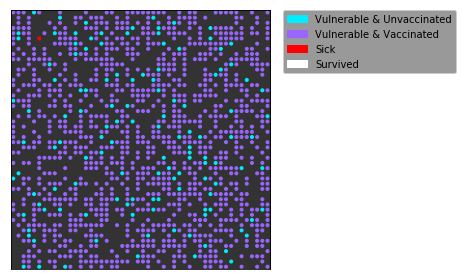

In [5]:
env = Disease(50, num_agents=1250, infection_range=2, seed=4)
viewer = DiseaseViewer(env)
viewer.draw()

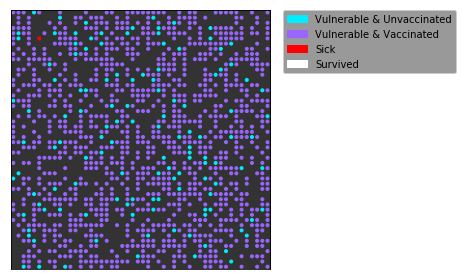

In [6]:
anim = viewer.animate(frames=100, interval=500)

In [7]:
# NOTE: This cell may take a minute or two to run through the simulations
anim

RuntimeError: Requested MovieWriter (ffmpeg) not available

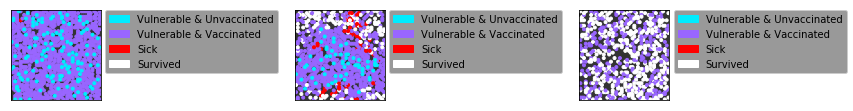

In [8]:
thinkplot.preplot(cols=3)
env = Disease(50, num_agents=1250, infection_range=2, seed=4)
viewer = DiseaseViewer(env)
viewer.draw()

thinkplot.subplot(2)
viewer.step(25)
viewer.draw()

thinkplot.subplot(3)
viewer.step(100)
viewer.draw()

plt.savefig('model_viewer.pdf')

The following shows the model with the vaccination rate decrease to 50% of the population, the infection time, infection range and infection rate have all been increased to create a more deadly disease, and the vaccine effectiveness was set to 95%.

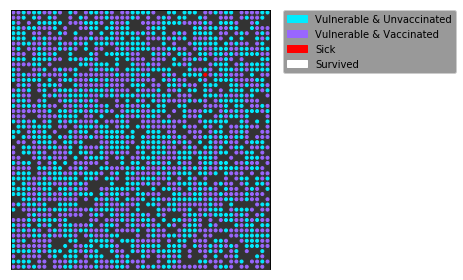

In [9]:
env = Disease(50, num_agents=2000, vaccination_rate=0.5, infection_time=6, infection_range=2, infection_rate=0.8, vaccine_effect=0.95)
viewer = DiseaseViewer(env)
viewer.draw()

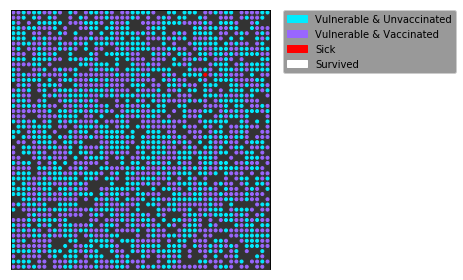

In [10]:
anim = viewer.animate(frames=100, interval=500)

In [11]:
# NOTE: This cell may take a minute or two to run through the simulations
anim

RuntimeError: Requested MovieWriter (ffmpeg) not available

In the animation above it can be seen that all of the agents who were not vaccinated got sick, and these agents would have either survived the disease or would have died from it. The disease in this simulation spreads a lot quicker than in the simulation above. 

## Herd Immunity

In [12]:
def plot_herd_immunity(vaccine_rate_arr):
    for vaccine_rate in vaccine_rate_arr:

        print("Running with vaccination rate = %0.2f" %(vaccine_rate) )

        env = Disease(50, seed=22, num_agents=1500, vaccination_rate=vaccine_rate, infection_time=6, infection_range=2, infection_rate=0.4, vaccine_effect=0.95)

        x = range(0, 100)

        for i in x:
            env.step()

        y = env.agent_count_seq
        plt.plot(x, y, linewidth=1, label="Vaccination Rate = %0.2f" %(vaccine_rate) )
        plt.xlabel('Time Steps')
        plt.ylabel('Number of Agents Alive')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Running with vaccination rate = 0.00
Running with vaccination rate = 0.25
Running with vaccination rate = 0.50
Running with vaccination rate = 0.75
Running with vaccination rate = 0.85
Running with vaccination rate = 0.90
Running with vaccination rate = 0.95
Running with vaccination rate = 1.00


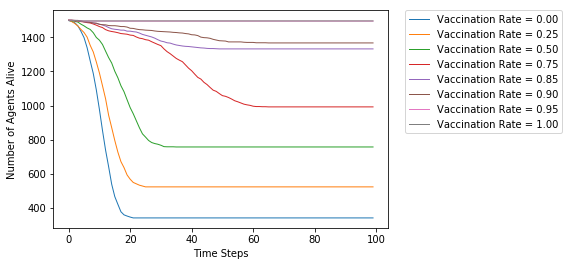

In [13]:
# NOTE: This cell may take a minute or two to run through the simulations
vra = [0, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 1]
plot_herd_immunity(vra)

Running with vaccination rate = 0.75
Running with vaccination rate = 0.79
Running with vaccination rate = 0.83
Running with vaccination rate = 0.88
Running with vaccination rate = 0.92
Running with vaccination rate = 0.96
Running with vaccination rate = 1.00


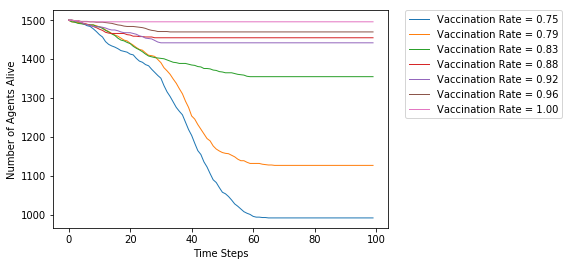

In [14]:
# NOTE: This cell may take a minute or two to run through the simulations
vra2 = np.linspace(0.75, 1, num=7)
plot_herd_immunity(vra2)

## Infection Rate

In [15]:
def plot_infection_rate(infection_rate_arr):
    for infection_rate in infection_rate_arr:

        print("Running with infection rate = %0.2f" %(infection_rate) )

        env = Disease(50, seed=22, num_agents=1500, infection_time=6, infection_range=2, infection_rate=infection_rate, vaccine_effect=0.95)

        x = range(0, 100)

        for i in x:
            env.step()

        y = env.agent_count_seq
        plt.plot(x, y, linewidth=1, label="Infection Rate = %0.2f" %(infection_rate) )
        plt.xlabel('Time Steps')
        plt.ylabel('Number of Agents Alive')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Running with infection rate = 0.00
Running with infection rate = 0.25
Running with infection rate = 0.50
Running with infection rate = 0.75
Running with infection rate = 0.80
Running with infection rate = 0.85
Running with infection rate = 0.90
Running with infection rate = 0.95
Running with infection rate = 1.00


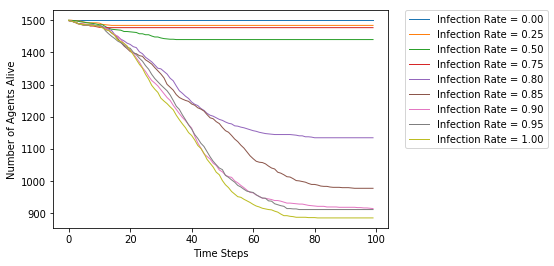

In [16]:
# NOTE: This cell may take a minute or two to run through the simulations
ira = [0, 0.25, 0.5, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
plot_infection_rate(ira)

Running with infection rate = 0.75
Running with infection rate = 0.79
Running with infection rate = 0.83
Running with infection rate = 0.88
Running with infection rate = 0.92
Running with infection rate = 0.96
Running with infection rate = 1.00


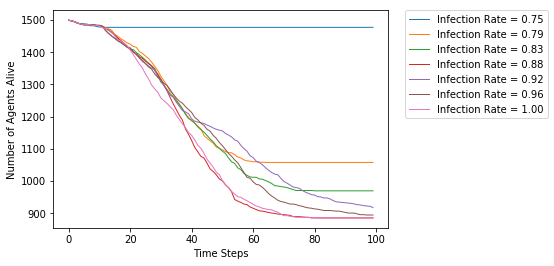

In [17]:
# NOTE: This cell may take a minute or two to run through the simulations
ira2 = np.linspace(0.75, 1, num=7)
plot_infection_rate(ira2)

## Infection Range

Running with infection range = 1
Running with infection range = 2
Running with infection range = 3


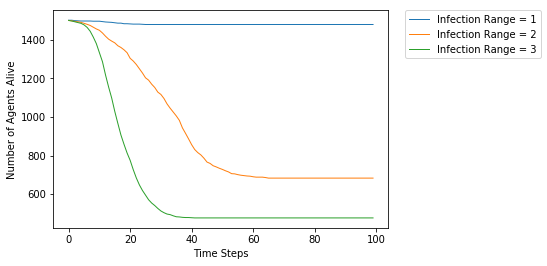

In [18]:
# NOTE: This cell may take a minute or two to run through the simulations
for inf_range in range(1, 4):

    print("Running with infection range = %d" %(inf_range) )

    env = Disease(50, seed=22, num_agents=1500, infection_time=6, infection_range=inf_range, infection_rate=0.6, vaccine_effect=0.9)

    x = range(0, 100)

    for i in x:
        env.step()

    y = env.agent_count_seq
    plt.plot(x, y, linewidth=1, label="Infection Range = %d" %(inf_range) )
    plt.xlabel('Time Steps')
    plt.ylabel('Number of Agents Alive')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Population Density

In [19]:
def plot_population_density(pop_density_arr):
    for pop_dens in pop_density_arr:

        print("Running with population density (# squares per agent) = %d" %(pop_dens) )

        n = 50
        num_squares = n * n
        num_agents = num_squares // pop_dens
                
        env = Disease(n, seed=22, num_agents=num_agents, infection_time=6, infection_range=2, infection_rate=0.6, vaccine_effect=0.9)

        x = range(0, 100)

        for i in x:
            env.step()

        y = [ (yi / num_agents) * 100 for yi in env.agent_count_seq]
        plt.plot(x, y, linewidth=1, label="Population Density (# squares per agent) = %d" %(pop_dens) )
        plt.xlabel('Time Steps')
        plt.ylabel('Percentage of Agents Alive')
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Running with population density (# squares per agent) = 1
Running with population density (# squares per agent) = 2
Running with population density (# squares per agent) = 3
Running with population density (# squares per agent) = 4
Running with population density (# squares per agent) = 5


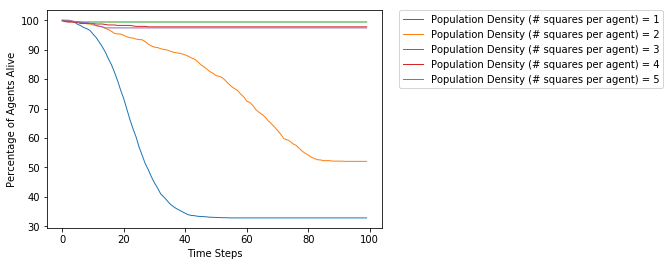

In [20]:
# NOTE: This cell may take a minute or two to run through the simulations
pda = range(1, 6)
plot_population_density(pda)